<a href="https://colab.research.google.com/github/hoangnguyenbao079/Apple_stocks_predict/blob/main/Apple_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import yfinance as yf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, avg
from pyspark.sql.window import Window

#Define start day to fetch the dataset from the yahoo finance library

In [11]:
# Tạo Spark session
spark = SparkSession.builder.appName("StockDataProcessing").getOrCreate()

# Thiết lập thời gian tải dữ liệu
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

In [12]:
# Hàm tải dữ liệu từ Yahoo Finance
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

In [18]:
# Bước 1: Tải dữ liệu từ Yahoo Finance
df = load_data("AAPL")

# ✅ Xử lý tên cột: xoá multi-level index
df.columns = [col if not isinstance(col, tuple) else col[0] for col in df.columns]

# ✅ In lại tên cột để kiểm tra
print(df.columns)

# Bước 2: Tạo Spark DataFrame từ Pandas
df_spark = spark.createDataFrame(df)


[*********************100%***********************]  1 of 1 completed

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


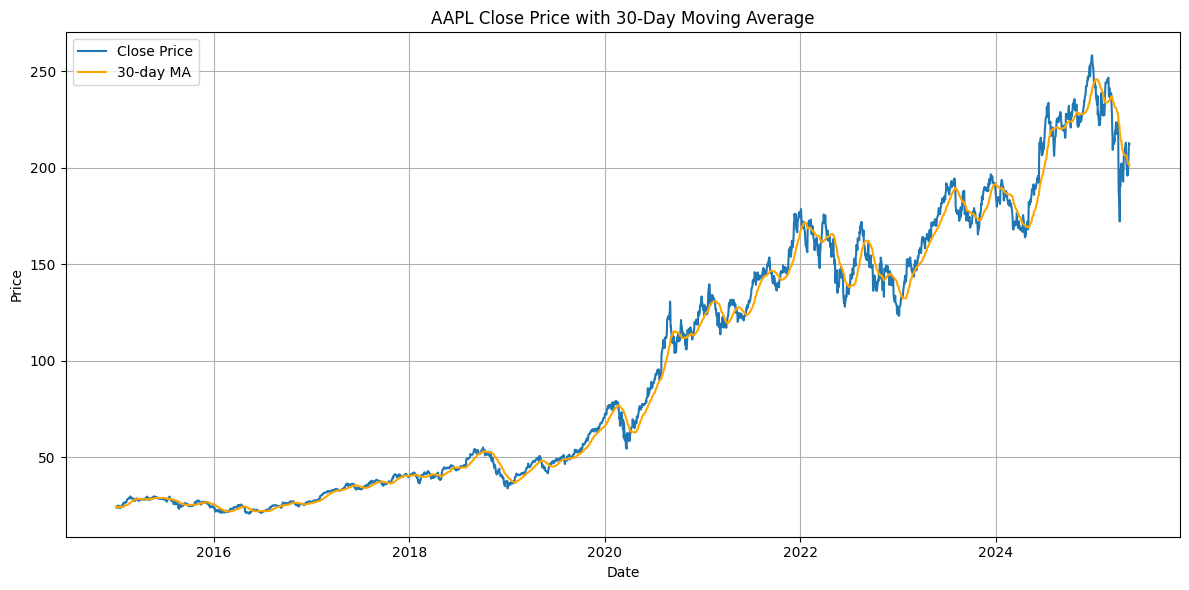

In [20]:
from pyspark.sql.functions import col, to_date, avg
from pyspark.sql.window import Window

# Đảm bảo cột 'Date' là kiểu ngày
df_spark = df_spark.withColumn("Date", to_date(col("Date")))

# Giữ lại các cột cần thiết
df_spark = df_spark.select("Date", "Close")

# Tính MA 30 ngày
windowSpec = Window.orderBy("Date").rowsBetween(-29, 0)
df_spark = df_spark.withColumn("MA_30", avg("Close").over(windowSpec))

# Sắp xếp theo ngày
df_spark = df_spark.orderBy("Date")

# Chuyển về Pandas để vẽ
df_plot = df_spark.toPandas()

# Vẽ biểu đồ
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df_plot["Date"], df_plot["Close"], label="Close Price")
plt.plot(df_plot["Date"], df_plot["MA_30"], label="30-day MA", color="orange")
plt.title("AAPL Close Price with 30-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
from pyspark.sql.functions import lag, when, lit
from pyspark.sql.window import Window

# Thêm cột change = Close - Close của ngày trước
windowSpec_lag = Window.orderBy("Date")
df_spark = df_spark.withColumn("prev_Close", lag("Close").over(windowSpec_lag))
df_spark = df_spark.withColumn("change", col("Close") - col("prev_Close"))

# Tính gain và loss
df_spark = df_spark.withColumn("gain", when(col("change") > 0, col("change")).otherwise(lit(0.0)))
df_spark = df_spark.withColumn("loss", when(col("change") < 0, -col("change")).otherwise(lit(0.0)))

# Cửa sổ 14 ngày để tính trung bình gain và loss
windowSpec_rsi = Window.orderBy("Date").rowsBetween(-13, 0)

df_spark = df_spark.withColumn("avg_gain", avg("gain").over(windowSpec_rsi))
df_spark = df_spark.withColumn("avg_loss", avg("loss").over(windowSpec_rsi))

# Tính RSI
df_spark = df_spark.withColumn(
    "RSI_14",
    when(col("avg_loss") == 0, lit(100))
    .otherwise(100 - (100 / (1 + col("avg_gain") / col("avg_loss"))))
)


In [23]:
df_spark.select("Date", "Close", "MA_30", "RSI_14").orderBy("Date").show(20)


+----------+------------------+------------------+------------------+
|      Date|             Close|             MA_30|            RSI_14|
+----------+------------------+------------------+------------------+
|2015-01-02|24.288583755493164|24.288583755493164|             100.0|
|2015-01-05|23.604331970214844|23.946457862854004|               0.0|
|2015-01-06|23.606555938720703|23.833157221476238|0.3239689812203608|
|2015-01-07|23.937572479248047| 23.85926103591919| 32.75115800839427|
|2015-01-08|24.857309341430664|24.058870697021483| 64.67884127262309|
|2015-01-09|24.883968353271484|24.196386973063152| 65.15831215285297|
|2015-01-12|24.270809173583984|  24.2070187159947| 49.65513668340593|
|2015-01-13| 24.48630142211914|24.241929054260254|53.540104979526596|
|2015-01-14| 24.39300537109375|  24.2587153116862| 51.80920933054595|
|2015-01-15|    23.73095703125|24.205939483642577|42.141418290179146|
|2015-01-16|23.546571731567383|24.145996960726652|  40.0595058013557|
|2015-01-20| 24.1530

In [25]:
df_plot = df_spark.select("Date", "Close", "MA_30", "RSI_14").orderBy("Date").toPandas()


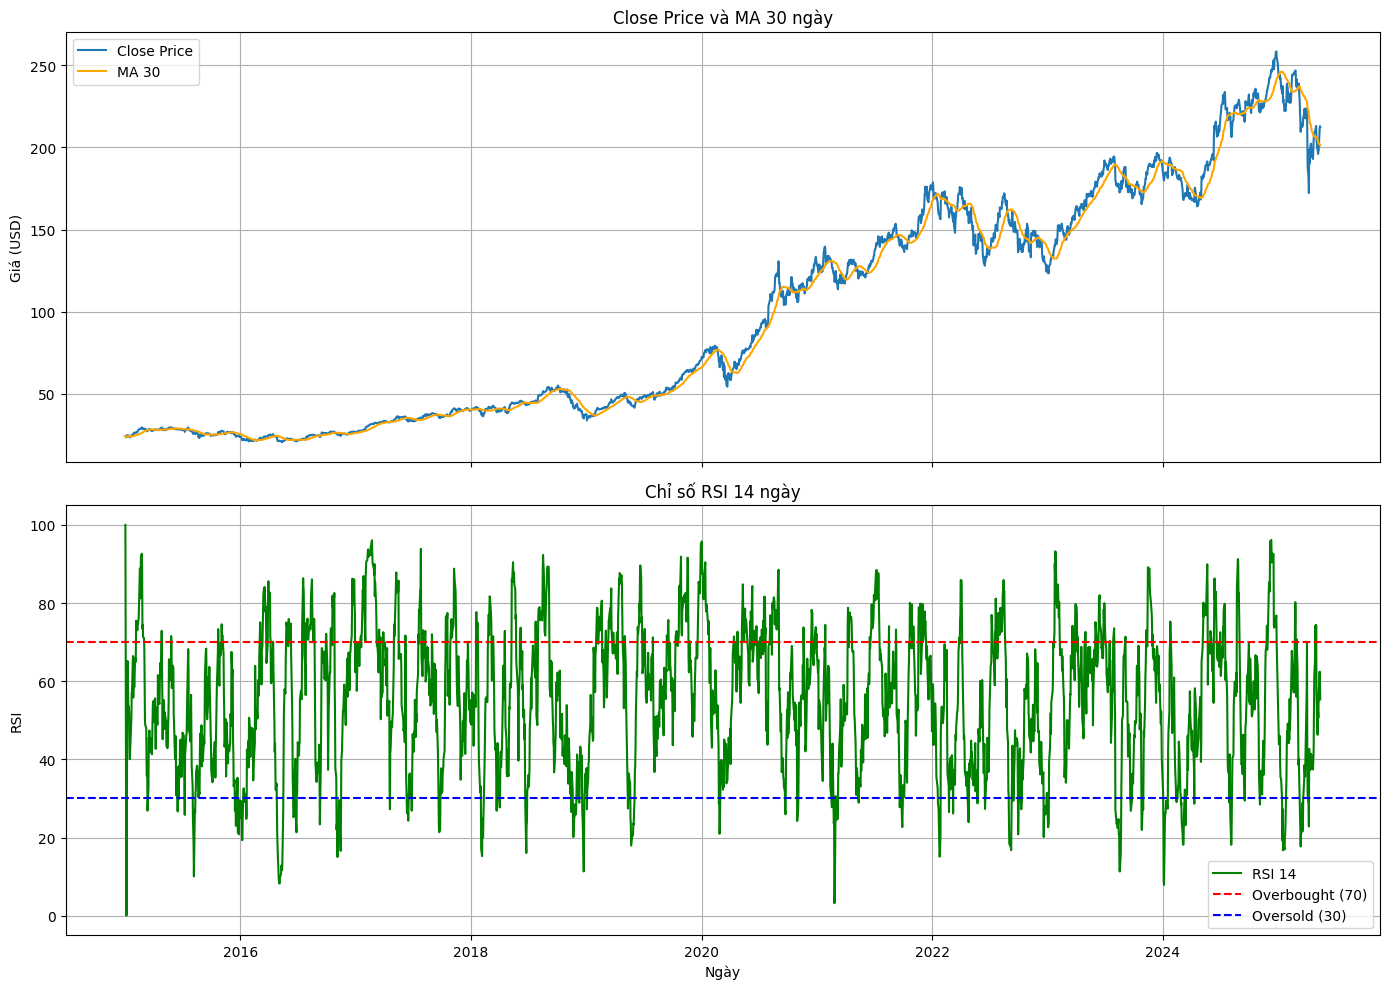

In [26]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Biểu đồ giá Close và MA_30
ax1.plot(df_plot["Date"], df_plot["Close"], label="Close Price")
ax1.plot(df_plot["Date"], df_plot["MA_30"], label="MA 30", color="orange")
ax1.set_title("Close Price và MA 30 ngày")
ax1.set_ylabel("Giá (USD)")
ax1.legend()
ax1.grid(True)

# Biểu đồ RSI 14 ngày
ax2.plot(df_plot["Date"], df_plot["RSI_14"], label="RSI 14", color="green")
ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
ax2.axhline(30, color='blue', linestyle='--', label='Oversold (30)')
ax2.set_title("Chỉ số RSI 14 ngày")
ax2.set_ylabel("RSI")
ax2.set_xlabel("Ngày")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [27]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# df_plot đã có các cột: Date, Close, MA_30, RSI_14

# Lấy chỉ cột Close để dự báo giá đóng cửa
data = df_plot[["Close"]].values

# Chuẩn hóa dữ liệu về [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Tạo dữ liệu theo cửa sổ thời gian (window_size = 60 ngày để dự báo ngày tiếp theo)
window_size = 60

X = []
y = []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape để đưa vào LSTM: (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Chia train/test 80% - 20%
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0145 - val_loss: 0.0015
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 8.9667e-04 - val_loss: 0.0025
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 8.5252e-04 - val_loss: 0.0015
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 6.8134e-04 - val_loss: 0.0031
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 6.8639e-04 - val_loss: 0.0017
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 6.4386e-04 - val_loss: 0.0028
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 5.1181e-04 - val_loss: 0.0020
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 5.6649e-04 - val_loss: 9.8503e-04
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 5.9380e-04 - val_loss: 0.0016
Epoch 12/20
64/64 ━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


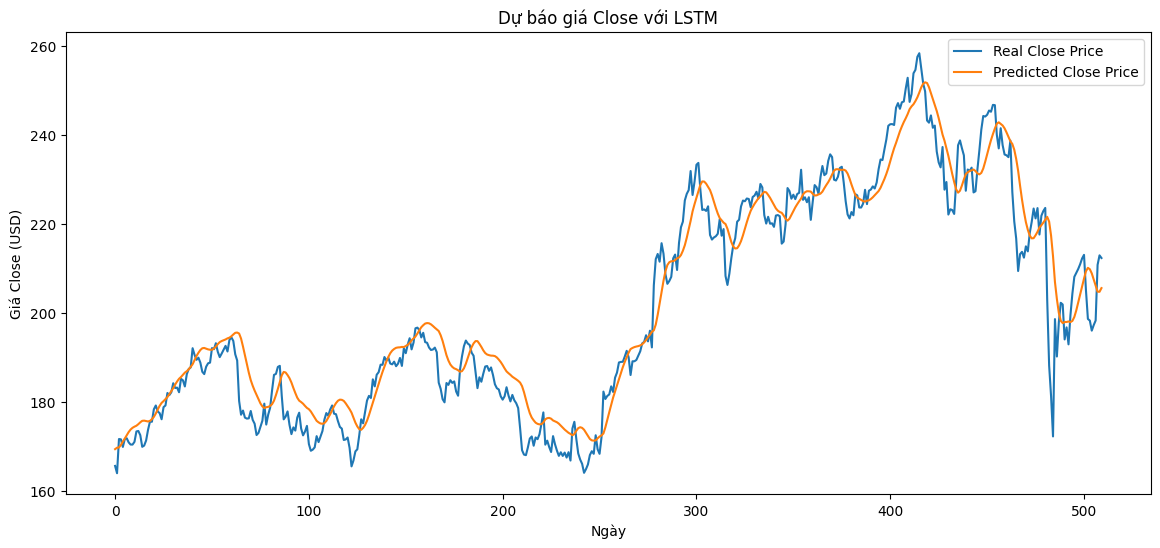

In [30]:
# Dự báo
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Lấy giá thật (giá Close) tương ứng test set
real_prices = scaler.inverse_transform(y_test.reshape(-1,1))

# Vẽ biểu đồ
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(real_prices, label='Real Close Price')
plt.plot(predictions, label='Predicted Close Price')
plt.title('Dự báo giá Close với LSTM')
plt.xlabel('Ngày')
plt.ylabel('Giá Close (USD)')
plt.legend()
plt.show()
